---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Avaliação de Risco de Crédito


Uma das área que causa mais problemas para bancos, financiadoras e empresários é a taxa de inadimplência por parte da sua carteira de clientes.

Avaliar se uma pessoa irá deixar de cumprir com suas obrigações financeiras é de extrema importância, e pode causar um grande impacto no balanço da Instituição. Cada vez mais, soluções vêm sendo desenvolvidas e aprimoradas visando minimizar o risco de *default*.

*Default* é o termo utilizado para indicado o não cumprimento das obrigações e/ou condições de um empréstimo (como financiamentos ou dívidas de cartão de crédito). Normalmente, o principal motivo para o descumprimento das condições de pagamento é incapacidade financeira do cliente.

<p align=center>
  <img src="https://images.unsplash.com/photo-1556742502-ec7c0e9f34b1?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=687&q=80" width="40%">
</p>

Grandes bancos e Fintechs têm apostado cada vez mais em modelos de *Machine Learning* para previnir a inadimplência de alguns clientes.


O conjunto de dados a ser utilizado neste Projeto de *Data Science* parte de uma competição realizada por uma startup a fim de revelar talentos e potenciais contratações pela Fintech.

## Contextualização do Problema

Neste problema, o objetivo é prever qual a probabilidade de um cliente da Fintech não coumprir com suas obrigações financeiras e deixar de pagar a sua fatura do Cartão de Crédito.

  
Vale ressaltar que essa avaliação deve ser realizada no momento em que o cliente solicita o cartão (normalmente no primeiro contato com a instituição).



> OBJETIVO: Criar um modelo que indique se um cliente irá virar inadimplente.


Espera-se que um modelo seja capaz de minimizar as perdas financeiras da Fintech, porém minimizando também os falsos positivos.

### Hipóteses Iniciais

## Importar os Dados

Os dados que serão utilizados nesta análise estão disponíveis para download por meio [deste link](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0). Consiste basicamente em um arquivo `csv` contendo 45.000 entradas e 43 colunas.

Este arquivo será importando para uma estrutura *DataFrame* utilizando a biblioteca `pandas` a fim de possibilitar sua manipulação e análise.

In [ ]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [ ]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# definir o estilo do seaborn para os plots
sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
df = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")

## Análise Exploratória de Dados

A primeira coisa que faremos após importar o *dataset* será examinar as dimensões do *DataFrame* e as primeiras entradas. Isso possibilitará criar uma consciência situacional inicial a respeito do formato de entrada e da estrutura geral dos dados.

Em relação à dimensionalidade dos dados, nosso *dataset* é composto por 45 mil entradas e 43 colunas.

In [ ]:
# dimensões do df
print("DIMENSÕES DO DATAFRAME:")
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

DIMENSÕES DO DATAFRAME:
Linhas:		45000
Colunas:	43


Já as primeiras 5 entradas desse conjunto de dados permitem adquirirmos uma noção inicial sobre o tipo de formato, exemplos de entrada e formulação das hipóteses iniciais do processo investigativo.

In [ ]:
# ver as 5 primeiras entradas
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN



Algumas conclusões iniciais que podem ser destacadas a respeito desse análise inicial:

* Existe uma coluna `id`, anônima, que representa um identificador único do cliente. Iremos eliminar esta coluna mais para frente, pois ela não contém nenhuma informação relevante.
* A variável alvo para analisar o risco de *default* (inadimplência) está na coluna `target_default`.
* As colunas `['score_3', 'score_4', 'score_5']` são numéricas e as colunas `['score_1', 'score_2']` estão codificadas de alguma maneira. Teremos que verificar a frente se existe uma quantidade de classes que possa ser convertida em informação útil.
* existem outras variáveis que apresentam algum tipo de codificação, como `['reason', 'state', 'zip', 'channel', 'job_name', 'real_state']` que estão codificadas e também precisarão de alguma análise mais aprofundada para saber se é possível extrair alguma informação das mesmas.
* A coluna `profile_tags` contém um dicionário com *tags* atribuídas a cada cliente, aparentemente.
* A coluna `target_fraud` seria a variável alvo de outro modelo para este mesmo *dataset*, onde o objetivo seria a detecção de fraude.
* A coluna `lat_lon` está em formato *string* contendo uma tupla com as coordenadas.

In [ ]:
# ver resumo estatístico do dados numéricos
df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


Olhando o resumo das principais informações estatísticas somos capazes de destacar algumas observações:

* A coluna `external_data_provider_credit_checks_last_2_year` possui valores mínimos, máximos e desvio-padrão iguais a zero.
* A coluna `reported_income` apresenta valores *inf*, que irão interferir na análise e modelo. Substituiremos valores do tipo `np.inf` por `np.nan` para trabalhar com os dados.
* A coluna `external_data_provider_email_seen_before` apresenta o valor mínimo de -999, o que é estranho ao se considerar as outras informações. Após verificar de maneira mais aprofundada, chegou-se a conclusão que esse dados são *outliers* ou foram tratados inadequadamente. Substituiremos os valores iguais a -999 por `np.nan`.

Vamos realizar o levantamento dos tipos de variáveis que compõem o *DataFrame* a fim de estabelecer a divisão entre as variáveis numéricas e as variáveis categóricas.

In [ ]:
# tipo das variáveis
print("\nTIPOS DAS VARIÁVEIS:")
print(df.dtypes)


TIPOS DAS VARIÁVEIS:
ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip               

Outra análise importante para se fazer é identificar a quantidade de dados ausentes por *feature*.

In [ ]:
# valores ausentes
print("\nVALORES AUSENTES:")
print((df.isnull().sum() / df.shape[0]).sort_values(ascending=False))


VALORES AUSENTES:
target_fraud                                        0.966178
last_amount_borrowed                                0.665689
last_borrowed_in_months                             0.665689
ok_since                                            0.589889
external_data_provider_credit_checks_last_2_year    0.502844
external_data_provider_credit_checks_last_year      0.336089
credit_limit                                        0.306667
n_issues                                            0.256533
facebook_profile                                    0.099067
marketing_channel                                   0.079511
job_name                                            0.074133
target_default                                      0.072422
external_data_provider_email_seen_before            0.049622
lat_lon                                             0.030289
user_agent                                          0.016044
n_bankruptcies                                      0.015489
n_def

Em relação à porcentagem de valores ausentes identificados neste *dataset*:

* Diversas variáveis como `['target_fraud', 'last_amount_borrowed', 'last_borrowed_in_months', 'ok_since', 'external_data_provider_credit_checks_last_2_year']` possuem mais da metade dos valores ausentes.

* As variáves `['external_data_provider_credit_checks_last_year', 'credit_limit', 'n_issues']` possuem entre 25-34% do seus valores ausentes.

* A variável alvo `target_default` contém valores nulos que serão eliminados do *dataset*.

Neste projeto, o caso mais extremo (`target_fraud`) não representa um problema, pois é uma variável alvo que não interessa para a análise de risco de inadimplência. Já as demais *features* deverão ser usadas com o devido cuidado.

Uma outra análise interessante de se fazer diz respeito à contagem de valore únicos por features. Muitas vezes, variáveis numéricas podem esconder classes/categorias que melhor representariam uma *feature*, ou revelar uma quantidade elevada de classes para "variáveis categóricas".

In [ ]:
# valores únicos
print("\nVALORES ÚNICOS:")
print(df.nunique().sort_values())


VALORES ÚNICOS:
external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               

A contagem de valores únicos mostra que as colunas `external_data_provider_credit_checks_last_2_year` e `channel` apresentam um único valor possível. Como não ha maiores informações sobre cada *feature* iremos descartar as duas colunas para o modelo de *Machine Learning*.

Também se percebe que `profile_phone_number` possui 45 mil valores únicos, não trazendo provavelmente nenhuma informação que possa contribuir para a análise.

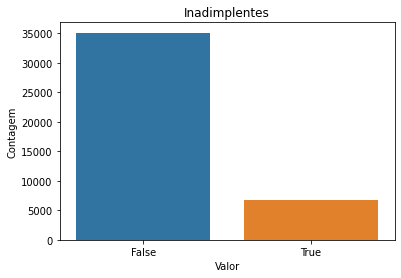

Proporção entre Inadimplentes no Dataset:
False    0.779556
True     0.148022
Name: target_default, dtype: float64


In [ ]:
# Proporção entre Inadimplentes no Dataset
fig, ax = plt.subplots()
sns.countplot('target_default', data=df, ax=ax)
ax.set_title("Inadimplentes")
ax.set_xlabel("Valor")
ax.set_ylabel("Contagem")
plt.show()

print("Proporção entre Inadimplentes no Dataset:")
print(df['target_default'].value_counts() / df.shape[0])

## Preparação dos Dados

Com as informações que obtivemos da etapa anterior, vamos prosseguir com a limpeza e preparação dos dados.

In [ ]:
df_clean = df.copy()

# substituir inf por nan em reported_income
df_clean['reported_income'] = df_clean['reported_income'].replace(np.inf,
                                                                  np.nan)

# descartar as colunas ids, target_fraud,
# external_data_provider_credit_checks_last_2_year e channel
df_clean.drop(labels=['ids', 'target_fraud',
                      'external_data_provider_credit_checks_last_2_year',
                      'channel'], axis=1, inplace=True)

#  substituir -999 em external_data_provider_email_seen_before por NaN
df_clean.loc[df_clean['external_data_provider_email_seen_before'] == -999.0,
             'external_data_provider_email_seen_before'] = np.nan

# elminar colunas sem informação aparente ou que demandam mais pesquisa
drop_var = ['reason', 'zip', 'job_name', 'external_data_provider_first_name',
            'lat_lon', 'shipping_zip_code', 'user_agent', 'profile_tags',
            'application_time_applied', 'email', 'marketing_channel',
            'profile_phone_number', 'shipping_state']
df_clean.drop(labels=drop_var, axis=1, inplace=True)

# elminar as entradas onde target_default é NaN
df_clean.dropna(subset=['target_default'], inplace=True)

Apesar de não haver maiores informações sobre as *features*, podemos assumir como premissa que muitos valores são nulos devido a dois fatores:

1. Há alguns itens que não são obrigatórios durante a etapa de preenchimento dos formulários, como a informação sobre o perfil do cliente no Facebook; e
2. Não existe observação alguma referente à coluna, como é caso das colunas `['last_amount_borrowed', 'last_borrowed_in_months', 'n_issues']`.

De maneira geral, para as variáveis que se enquadram no segundo caso, os valores `NaN` serão substituidos por zero. Para as variáveis numéricas, será adotado o valor da mediana, e para as categóricas o valor mais frequente.

In [ ]:
from sklearn.impute import SimpleImputer

num_df = df_clean.select_dtypes(exclude='object').columns
cat_df = df_clean.select_dtypes(include='object').columns

# substituição de valores ausentes
df_clean.last_amount_borrowed.fillna(value=0, inplace=True)
df_clean.last_borrowed_in_months.fillna(value=0, inplace=True)
df_clean.n_issues.fillna(value=0, inplace=True)

# variáveis numéricas
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_clean.loc[:,num_df])
df_clean.loc[:,num_df] = imputer.transform(df_clean.loc[:,num_df])

# variáveis categóricas
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_clean.loc[:,cat_df])
df_clean.loc[:,cat_df] = imputer.transform(df_clean.loc[:,cat_df])

Podemos agora verificar que as variáveis escolhidas não possuem mais os valores nulos iniciais.

In [ ]:
# verificar a quantidade de dados nulos
df_clean.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
facebook_profile                                   0
state                                              0
real_state                                         0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                    

**EXERCÍCIO: Refaça o gabarito seguindo as melhores práticas de validação e padronização.**

Para melhorar o desempenho do modelo, irei normalizar as variáveis numéricas usando `StandardScaler`.

In [ ]:
# criando uma cópia do df
scaled_df = df_clean.copy()

# normalizar as colunas numéricas
num_cols = scaled_df.drop('target_default',
                         axis=1).select_dtypes(exclude='object').columns

scaled_df[num_cols] = StandardScaler().fit_transform(scaled_df[num_cols].values)

Continuando com a preparação dos dados, irei realizar o Label Encoding para possibilitar que as variáveis categóricas possam ser codificadas em forma de *labels* e alimentar o modelo de *Machine Learning*.

In [ ]:
# criando uma cópia do df
encoded_df = scaled_df.copy()

# extrair as colunas categóricas
cat_cols = encoded_df.select_dtypes('object').columns

# codificar cada coluna categórica
for col in cat_cols:
  encoded_df[col+'_encoded'] = LabelEncoder().fit_transform(encoded_df[col])
  encoded_df.drop(col, axis=1, inplace=True)

Por fim, irei separar a variável alvo das demais e dividir o *dataset* entre dados de treino e teste com a função `train_test_split`.

In [ ]:
# separar as variáveis independentes da variável alvo
X = encoded_df.drop('target_default', axis=1).select_dtypes(exclude='object')
y = encoded_df['target_default']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Construção do Modelo

Após separarmos os dados entre dados de teste e treino, precisamos:

* Criar uma baseline a ser batida. Idealmente, usaríamos os resultados da solução atual empregada pela empresa, ou até uma métrica que não utilize *Machine Learning*. Como não estamos inseridos nesse cotexto, utilizaremos um modelo arbitrário, não parametrizado, como baseline.
* Definir a melhor métrica para avaliar nosso modelo.
* Comparar modelos diferentes levando a métrica alvo e o baseline como comparação.
* Tunar os hiperparâmetros em um conjunto de validação.
* Rodar o modelo em nossos dados de teste.


Arbitrariamente, escolhi o `RandomForestClassifier` para a construção do baseline.

Não foi realizada uma análise mais aprofundada sobre as variáveis e nem um *tunning* de parâmetros, mas construído um modelo simples para servir de *baseline*.

### Métricas e Modelos

Para decidirmos que métrica usar, precisamos analisar algumas de nossas opções.

* Caso optemos pela `Acurácia`, precisamos estar cientes que esse pode não ser o método ideal, mas para uma análise inicial do problema, pode nos ajudar a criar uma solução generalista.

* Caso optemos por otimizar o modelo a partir do `Recall`, estamos priorizando que não haja Falsos Negativos. Ou seja, é preferível negar um cliente que não traria prejuízo à empresa, do que aceitar um que traga. Essa é a forma que são tratados, por exemplo, fraudes em cartão de crédito, modelos médicos, etc.

* Caso optemos por otimizar a partir do `Precision`, essencialmente, estamos dizendo que Falsos Positivos são ok, e não queremos ter Falsos Negativos. Basicamente, é preferível aceitar clientes que possam trazer prejuízo, do que deixar de aceitar clientes que não trarão. Essa é a forma que são tratados, por exemplo, modelos para spam de e-mails.

Aqui, vamos utilizar a `Acurácia`, no intuito de realizar uma análise generalista, deixando o *fine-tuning* de métricas e modelos para o talento dos alunos.

O que vai definir a melhor métrica é a estratégia de negócio da empresa, e seus valores. Também por isso, vamos utilizar essa métrica mais "genérica".

Dito isso, mãos à obra!

In [ ]:
# construindo função de avaliação do baseline
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """

    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy')

    if quite == False:
        print("Acurácia: {:.4f} (+/- {:.2f})".format(scores.mean(), scores.std()))

    return scores.mean()

# criar baseline e ver desempenho
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Acurácia: 0.8381 (+/- 0.00)


Apesar de estarmos lidando com dados desbalanceados, e um modelo que não recebeu nenhum tuning de hiperparâmetros, nossa baseline é bastante competente.

Com acurácia na casa de 83%, vamos ver o que podemos fazer para bater essa baseline.

### Modelos

Para tentar bater essa baseline, vamos testar diferentes modelos:

* Random Forest Classifier (Baseline)
* Decision Tree Classifier
* SGD Classifier
* SVC
* Logistic Regression
* XGB Classifier
* LGBM Classifier

In [ ]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
acc = []
# avaliar o desempenho
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    acc.append(val_model(X_train, y_train, clf, quite=True))

pd.DataFrame(data=acc, index=model, columns=['acc'])

,acc
RandomForestClassifier,0.838011
DecisionTreeClassifier,0.739236
SGDClassifier,0.836744
SVC,0.837292
LogisticRegression,0.837087
XGBClassifier,0.838764
LGBMClassifier,0.838422


Ao realizar os testes com diferentes modelos, podemos ver que o `XGBClassifier`retornou os melhores resultados.

A margem foi pequena, o que suegere que, dada a devida parametrização, qualquer modelo dessa lista poderia ser tão eficiente ou até mais eficiente do que o XGB, mas devido ao seu resultado inicial, iremos seguir com ele.

Além de pesquisas externas, ver o que o pessoal que obtém bons resultados com esse modelo mexe em relação a parâmetros, e a própria documentação do modelo, podemos utilizar o método `get_params` para visualizar que parâmetros podem ser tunados para obtermos os melhores resultados.

Para mais referência em relação ao tuning de hiperparâmetros do XGBClassifier, veja esse [link](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e).

In [ ]:
# verificando os parâmetros
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
# instanciando o modelo
xgb = XGBClassifier(random_state=42)

# definindo os parâmetros a serem testados
param_grid = {
  'learning_rate': [0.001, 0.01, 0.1],
  'gamma':[0, 1, 5],
  'subsample':[0.5, 1.5, 3.5],
  'max_depth': [1, 3, 5],
  'n_estimators': [100, 500, 1000],
  'colsample_bytree': [0.1, 0.5, 1]
 }

# identificar melhores parâmetros
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# ver resultados
print("Melhor: {:.2f} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.84 para {'colsample_bytree': 0.1, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.5}


In [ ]:
# instanciando o modelo e treinando o mesmo
ml_model = XGBClassifier(learning_rate=0.1, max_depth=1, gamma=5,
                         n_estimators= 1000, min_child_weight=1,
                         subsample = 0.5, colsample_bytree = 0.1,
                         random_state=42)

ml_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=5,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [ ]:
# previsões e probabilidades em cima do dataset de teste
y_pred = ml_model.predict(X_test)

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

Acurácia: 0.8476



Lembra-se que o *dataset* utilizado neste projeto é desbalanceado, o que pode gerar métricas que não representam a realidade da situação problemática do mundo real.

**EXERCÍCIO: Faça testes com o dataset balanceado.**

Que tal testar diferentes técnicas de balanceamento? Smote, undersampling, oversampling? Você já teve contato com algumas delas no último módulo.

Sem ser exaustivo, será apresentada apenas a acurácia do modelo como métrica simples de avaliação.

Pode-se assumir a premissa de que este é um problema multiobjetivo de otimização, onde espera-se minimizar tanto a quantidade de *false positives* quanto maximizar a quantidade de *true positives*.

Para esta etapa inicial, a utilizacão da métrica acurácia pode ser estabelecida a fim de comparação entre diferentes modelos de *Machine Learning* (ou estabelecer um *benchmark*).

Como ação futura, recomenda-se tentativas em relação ao balanceamento dos dados, feature engineering, outras formas de pré-processamento de dados, otimização levando em consideração outras métricas de avaliação, etc.

Também seria interessante a utilização de *Problem Structuring Methods* para definir pesos para cada objetivo individual a fim de estabelecer uma função objetivo para a modelagem.